# Interaction Retrieval
Filter interactions between Cyclists and other traffic participants.

In [1]:
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import LineString
from shapely.plotting import plot_line

In [3]:
from data.load import load_trajectory_file, load_metadata
from visualization.trajectory import plot_trajectory

In [4]:
df = load_trajectory_file("../data/raw/tumdot_muc_part_1.csv")
metadata = load_metadata("../data/raw/meta_information.json")
labels = metadata["categories"]

bicycle = df[df["category"] == labels["bicycle"]]
bicycle_ids = bicycle["track_id"].unique()

car = df[df["category"] == labels["car"]]
car_ids = car["track_id"].unique()

## Indexing trajectories
Challenge: Efficient knn-trajectory retrieval

Solution: STR-Tree for indexing + post-filtering

### STR-Tree

Simplification of trajectories and splitting into segments for optimal Tree pruning.


In [5]:
from data.transform import traj_to_linestring, traj_list_to_linestrings
from maneuvers.interaction_detection import simplify_and_segment
from shapely.plotting import plot_line

Raw trajectory:
num_points: 516
distance: 110.42446662080793

Simplified trajectory:
num_points: 516
distance: 110.42446662080793
number of segments: 5


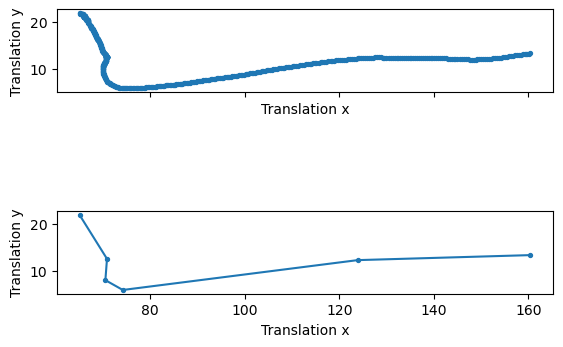

In [6]:
idx = 10
tolerance = 1

fig, axs = plt.subplots(2, sharex=True)

trajectory = df[df["track_id"] == bicycle_ids[idx]]
plot_trajectory(trajectory["translation_x"], trajectory["translation_y"], ax=axs[0])


line = LineString([(x, y) for x,y in zip(trajectory["translation_x"], trajectory["translation_y"])])
print(f"Raw trajectory:\nnum_points: {len(trajectory["translation_x"])}\ndistance: {line.length}")

simplified = line.simplify(tolerance)
x, y = simplified.xy
print(f"\nSimplified trajectory:\nnum_points: {len(trajectory["translation_x"])}\ndistance: {line.length}")
plot_trajectory(x, y, ax=axs[1])


print("number of segments:", len(y)-1)

#### Simplification tolerance
Visualizing the effect of the simplification `tolerance` on the simplicity of trajectories and the number of segments.

Number of segments: 2 
Length: 179.5284617084806 
Avg Seg Length: 89.7642308542403


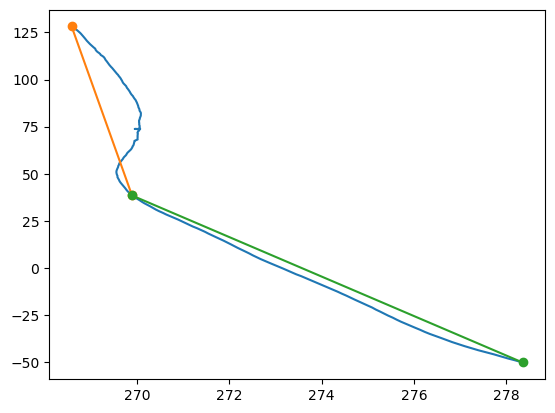

In [20]:
idx = 95
tol = 0.9

ids = car_ids
#print("cyclist track_id:", ids[idx])
line = traj_to_linestring(df[df["track_id"] == ids[idx]])

x, y = line.xy
plt.plot(x,y)

segments = simplify_and_segment(line, simplify_tol=tol)
print("Number of segments:", len(segments), "\nLength:", line.length, "\nAvg Seg Length:", line.length/len(segments))
for seg in segments:
    xs, ys = seg.xy
    plt.plot(xs, ys, marker="o", label="segment")

plt.show()

Effect of the tolerance on the number of segments and the average length per segment

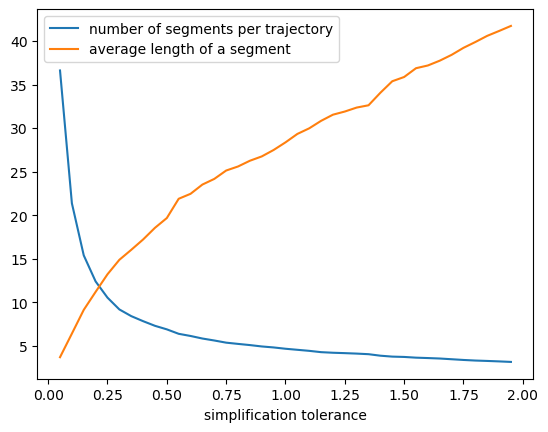

In [8]:
tols = np.arange(0.05, 2.0, 0.05)

counts = []
avgs = []

ids = bicycle_ids

for tol in tols:
    segments_count = 0
    avg_length = 0
    for idx in ids:
        line = traj_to_linestring(df[df["track_id"] == idx])
        segments = simplify_and_segment(line, simplify_tol=tol)
        segments_count += len(segments)
        avg_length += line.length / len(segments)
    counts.append(segments_count / len(ids))
    avgs.append(avg_length / len(ids))

plt.plot(tols, counts, label="number of segments per trajectory")
plt.plot(tols, avgs, label="average length of a segment")
plt.xlabel("simplification tolerance")
plt.legend()
plt.show()

## Interactions

Interaction filtering using the STR-Tree: 

1. Query Tree to find candidates using a tube around the target trajectory
2. Filter and verify candidates, by calculating distance for each timestamp
3. Find start and end timestamp of the interaction
4. Compute additional interaction features
5. save to CSV

In [9]:
from maneuvers.interaction_detection import detect_interactions, get_interactions, save_interactions_to_csv
from visualization.trajectory import plot_interactions
from data.utils import get_time_window
import random

cyclist id: 215
Number of Interactions: 18


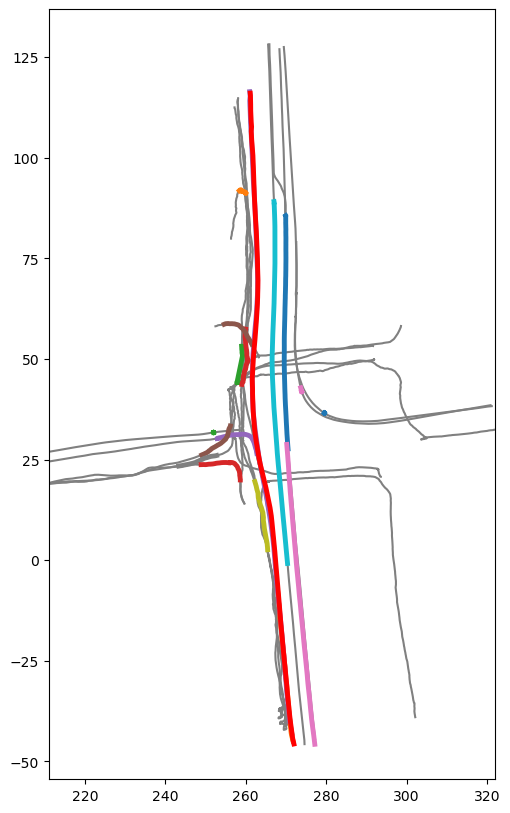

In [53]:
idx = random.randint(0, bicycle_ids.size)
distance = 25
print("cyclist id:", bicycle_ids[idx])
interactions = get_interactions(df, [bicycle_ids[idx]], distance=25, batch_size=5, min_duration=3)
save_interactions_to_csv(interactions, "../data/events/interactions/test_1.csv")
print("Number of Interactions:", len(interactions))

plot_interactions(df, bicycle_ids[idx], interactions)
plt.show()

In [14]:
interactions_df = pd.read_csv("../data/events/interactions/interactions_cyclist-cyclist_radius_10m.csv")
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21943 entries, 0 to 21942
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   track_id     21943 non-null  int64  
 1   other_id     21943 non-null  int64  
 2   t_start      21943 non-null  float64
 3   t_end        21943 non-null  float64
 4   duration     21943 non-null  float64
 5   dist_min     21943 non-null  float64
 6   dist_mean    21943 non-null  float64
 7   rel_speed    21943 non-null  float64
 8   rel_heading  21943 non-null  float64
 9   is_crossing  21943 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 1.7 MB


### Visual Check

Visually verifying interactions and getting intuition on the interaction data

(273, 328, 32.96, 35.36, 2.4, 5.123, 6.961, 6.738, 2.797, 0)
[273, 328]


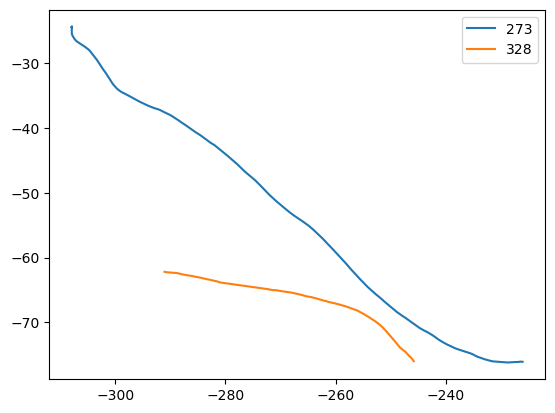

In [40]:
mask = (interactions_df["duration"] > 1) & (interactions_df["rel_heading"] > 2.5)
subset = interactions_df[mask]
tuples = list(subset.itertuples(index=False, name=None))
tupl = tuples[11]
print(tupl)
ids =[tupl[0], tupl[1]]
print(ids)
trajs = df[df["track_id"].isin(ids)]
#trajs = trajs[(trajs["timestamp"] >= tupl[2]) & (trajs["timestamp"] <= tupl[3])]
traj_dict = traj_list_to_linestrings(trajs)

fig, ax = plt.subplots(1, sharex=True)

for i in range(2):
    t = tupl[i]
    x,y = traj_dict[t].xy
    ax.plot(x, y, label=t)
    #ax.set_aspect('equal')

plt.legend()
plt.show()